###CNN implementation in Jax

The following is a basic implementation of a CNN completely in Numpy with Jax to aid in gradient calculation. 

The implementation relies on im2col method to ensure that calculations are done as large matrix multiplications, with minimal looping to allow a relatively efficient implementaion. 


* Achieved Accuracy of 61.75% on CIFAR-10 
*Achieved Accuracy of 99.03% on MNIST
*Achieved Accuracy of 90.53% on Fashion_MNIST



How to Use: 

In [1]:
import jax.numpy as np
import jax
import numpy as onp
import matplotlib.pyplot as py
import tensorflow as tf #this is only for dataset loading. 
tf.config.experimental.set_visible_devices([], "GPU")
from jax import grad,jit,vmap
from keras.utils import to_categorical

import timeit
from jax import device_put

Using TensorFlow backend.


In [2]:
(train_data,train_labels),(test_data,test_labels)=tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
train_data=device_put(train_data, jax.devices('gpu')[0])
train_labels=device_put(train_labels, jax.devices('gpu')[0])
test_data=device_put(test_data, jax.devices('gpu')[0])
test_labels=device_put(test_labels, jax.devices('gpu')[0])

### Main Convolution Functions

In [ ]:
#Maxpooling operation, takes a numpy matrix of shape (depth,width,height), applies a max on a kernel of shape (nrows,ncols) for each feature map 
def max_pool(image, nrows, ncols): 
    #Splits into submatrix and output max value
    output=[]
    d,ow,oh = image.shape
    for i in range(image.shape[0]): #this is repeated for each filter. 
      array=image[i].reshape(ow,oh)
      r, h = array.shape
     
      temp=(array.reshape(h//nrows, nrows, -1, ncols)
                  .swapaxes(1, 2)
                  .reshape(-1, nrows, ncols))
        
      output.append(np.max(temp.reshape(-1,4),axis=1))
    output=np.array(output)
     
    output=output.reshape(image.shape[0],int(ow/nrows),int(oh/ncols))
    return output


In [ ]:
#This function is technically incorrectly labelled as an adjacency matrix function. 
#The function generates a vector of shape (padded_image_height * padding_image_width, un_padded_image_height*un_padded_image_width) 
#Using this function, the indices for each convolution can be determined for the incomming image to allow that data to be quickly mapped into columns as you will see in
#the 'im2col' function. By default the function is limited to 3x3 kernel, however the kernel size can technically be changed.

#Note: the adj_matrix assumes that the image will have 'same' method of padding. 
def adj_matrix(row,height,padding):  
  padding=padding*2
  row=row+padding
  height=height+padding
  am =onp.zeros(((row)*(height),(row-padding)*(height-padding))) #adj matrix with 11*11 inputs, with 1 kernel doing an entire convolution for now. Imagine the first diemsnion like a linear line (For now only works on equal sized images. 
  
  #one row has (max length-kernel_size) (so 30-3 or 27 strides per row, with 27 stides in columbs 
  #This builds the pseudo 'adjacency' matrix. 

  start=0
  end=3
  jump = row #The jump is a row length
  mod=0
  ctr=0
  for i in range(row-padding): #assigning the pixels to a given stride, which is maxed out at 28*28 due to assumed 'same' padding. 
    for j in range(height-padding):
      am[start+mod:end+mod,ctr]=1
      am[start+mod+jump:end+mod+jump,ctr]=1
      am[start+mod+jump+jump:end+mod+jump+jump,ctr]=1
      mod+=1
      ctr+=1 
    start=end-1
    end =start+3

  return am 

#im2col uses the pseudo adjacency matrix generated to generate the transform the image into all convolutions, and transforms all the convolutions into columns to allow 
#fast compute due to the use of matrix multiplication without loops. 
#This function does this by taking the tranpose of the pseudo adjacency matrix and performs a pairwise multiplication with padded placeholder matrix, to generate a 
#vector containing all the indices of a given shaped input into a large matrix. 

def im2col(row,height,depth,padding):
  padded_image=onp.ones(((row+(padding*2))*(row+(padding*2)))).astype('float16')
  am=adj_matrix(row,height,padding)
  indices=am.T*padded_image #this can theoretically be used to make any shaped kernels, by modifying the way the pseudo-adjacency matrix is created. 
  window_indices=[]
  image_indices=[]
  for i in range(row*height):
    window_indices.append(onp.nonzero(indices[i])[0])
  window_indices=np.array(window_indices).T
  image_indices.append(window_indices)
  for i in range(1,depth): #This adds the additional indices for each layer of the image.
    window_indices=window_indices+((row+(padding*2))*(row+(padding*2)))
    image_indices.append(window_indices)
  return onp.array(image_indices)

#This function adds padding aroud any image such that after convolution is performed the resultant image will have the same dimensions
#as the input. This function is also known as 'same' padding in tensorflow.

def add_pad (image_,kernelw_,kernelh_):  #input image are channel,h,w
  #new add_pad
  d,h,w=image_.shape
  #d=1
  padw=onp.zeros((d,w,onp.divmod(kernelw_,2)[0]))

  padded=np.concatenate([padw,image_],axis=2) #you want to add, at the start if a 
  padded=np.concatenate([padded,padw[:]],axis=2)

  padh=onp.zeros((d,onp.divmod(kernelh_,2)[0],padded.shape[2]))

  padded=np.concatenate([padh,padded],axis=1)
  padded=np.concatenate([padded,padh],axis=1)
  return padded

#This is the convolution function, which does not use any loop, making it a relatively fast computation. The convolution takes a kernel  of 3x3xdepth shape (or shaped
#defined by the adjacency matrix, performs a dot product with the equvilant shaped weight matrix for a given number of filters as defined by the parameters. 

def conv (input_image,parameter,im2col_matrix): #parameter will be shaped. [layer,weight/bias,filter#], on input the parameter will be just [weight/bias,filter#]
  d,h,w = input_image.shape
  kh,kw=parameter[0][0][0].shape #fetches the kernel size
  
  weights=parameter[0].reshape(-1,d*kh*kw) #changes the kernel into [filter,3*3] to linearlize. 

  input_image=add_pad(input_image,kh,kw) #add padding 
  input_image = input_image.flatten() 
  conv_image=input_image[im2col_matrix].T 
  conv_image=conv_image.reshape(w*h,kh*kh*d) #Flattens the kernel into a row, allowing a dot product to be performed on all the filters at once. 
  convolved=(np.dot(conv_image,weights.T) + parameter[1]).T
  convolved=convolved.reshape(len(parameter[0]),h,w)

  return convolved

jit_conv_layer=conv #Jax is used to just_in_time compile to further speed up the convolution. 
  


###Weight Initialization

In [ ]:
#so the weights will be the shape.
#number of filters,image_depth,kernelW,kernelH.

def init_conv_parameters(filters,size,image_depth):  
  trainable_v=[]
  size_f=size[0]*size[1] 
  trainable_v.append([]) #new layer
  trainable_v[0].append(onp.random.rand(filters[0],image_depth, size[0],size[1])) #this assumes first channel is 1 so this will not work with RBG channels for now. 
  trainable_v[0].append(onp.random.randn(filters[0]))#bias
  #trainable_v[0].append(onp.zeros(filters[0]))#bias
  for i in range(1,len(filters)):  #for a given layer 
    trainable_v.append([])
    trainable_v[i].append(onp.random.rand(filters[i],filters[i-1],size[0],size[1])) #The kernel will be previous layer size. for now assume it's square. 
    trainable_v[i].append(onp.random.randn(filters[i]))
    #trainable_v[i].append(onp.zeros(filters[i]))
  return trainable_v


def init_parameters(shapes,input_shape=784):  
    onp.random.seed(1000)
    trainable_v=[[]]
    #first layer
    trainable_v[0].append(onp.random.randn(shapes[0],input_shape)) #input
    trainable_v[0].append( onp.random.randn (shapes[0])) #bbias 
    for i in range(1,len(shapes)): 
      trainable_v.append([]) #creates new layer?
      trainable_v[i].append(onp.random.randn(shapes[i],shapes[i-1]))
      trainable_v[i].append(onp.random.randn(shapes[i]))
    return trainable_v


### Activation Functions

In [ ]:
def tanh_act(x): 
    return np.tanh(x)
def sigmoid_act(x): 
  return jax.nn.sigmoid(x)
def softmax_act(x): 
    #return np.exp(x)/(np.sum(np.exp(x)))
    return jax.nn.softmax(x)
def binary_crossentropy(x,y): #x=input, y= target
    return -y*np.log(x)-(1-y)*np.log(1-x)
    #return jax.nn.binary_crossentropy(x,y)
def relu_act(x): 
  return jax.nn.relu(x)
def normalize(x): 
  return jax.nn.normalize(x,axis=0)

#Network

In [ ]:
def forward(params,input):
  #2 Convolution Layers.
  layer1=jit_conv_layer(input,params[0],im2col_matrix_layer1)
  layer1=relu_act(layer1)
  sampler=layer1
  layer1=max_pool(layer1,2,2) #28--14
 

  layer2=jit_conv_layer(layer1,params[1],im2col_matrix_layer2)
  layer2=relu_act(layer2)
  layer2=max_pool(layer2,2,2) #14-7


  ###FC network starts
  layer2=layer2.flatten()
  l1=np.dot(layer2,params[2][0].T)+params[2][1]
  l1=jax.nn.normalize(l1)
  l1=relu_act(l1)
  
  l2=np.dot(l1,params[3][0].T)+params[3][1] 
  l2=jax.nn.normalize(l2)

  
  l2=softmax_act(l2)
  return [l2,sampler]

vmap_forward=vmap(forward,in_axes=(None,0)) #jax.vmap is used to vectorize the process to allow for batching. 


def NLL(x,y): 
    return -np.log(x[np.argmax(y)]) #assuming one hot


def NLL_loss(params,i,t): 
  pred,_=jit(forward)(params,i)
  final=jit(NLL)(pred,t)
  return final


#Function to update parameters after gradient is calculated. 
#assumes the gradient input has shape [batch_size,weight matrix]
#Mini-batch SGD --> summed gradients. 
def update_weights(params, gradient ,lr=1.0): 
  for i in range(len(params)): #iterate through the layer. 
    params[i][0]=params[i][0]-(lr*np.sum(gradient[i][0],axis=0))
    params[i][1]=params[i][1]-(lr*np.sum(gradient[i][1],axis=0))
  return params


gradient=jit(grad(NLL_loss,argnums=(0)))
vmap_backprop = vmap(gradient,in_axes=(None,0,0))
jit_grad =jit(vmap_backprop)



In [ ]:
test_data.shape

(10000, 32, 32, 3)

In [ ]:
#Preparing and normalizing data. 

train_data=train_data.reshape(60000,1,28,28)/255.0
#train_data=train_data.transpose((0,3,1,2))/255.0
train_label=to_categorical(train_labels)

#test_data=test_data.transpose((0,3,1,2))/255.0
test_data=test_data.reshape(10000,1,28,28)/255.0
test_label=to_categorical(test_labels)

In [ ]:
#initializing weights.

onp.random.seed(1100)
conv_params =init_conv_parameters(filters=[32,16],size=[3,3],image_depth=1)
fc_params=init_parameters([300,10],input_shape=784)
params=conv_params+fc_params #totalling 2 convs layers, 2 fc layers 
im2col_matrix_layer1=im2col(row=28,height=28,depth=1,padding=1) #This is the initial size so mnist starts at 1, but with 4 filters the next layer will be 4. 
im2col_matrix_layer2=im2col(row=14,height=14,depth=32,padding=1)
#im2col_matrix_layer3=im2col(row=7,height=7,depth=32,padding=1)

###Main Training Loop

In [ ]:
dense_jit=jit(vmap_forward) #speed up
#jit_backprop=jit(vmap_backprop)
jit_update_weights=jit(update_weights)

ctr=0

for i in range(10): #epochs
  start_time = timeit.default_timer()
  for j in range(400): #number of batches to iterate.
    
    dparams=jit_grad(params,train_data[ctr:ctr+100],train_label[ctr:ctr+100]) #The last value is batch size
    params= jit_update_weights(params,dparams,lr=1.00)
    ctr=ctr+100

    if ctr+100>40000:
      ctr=0
  elapsed = timeit.default_timer() - start_time
  print (f'epoch time: ' ,elapsed)  
  pred,_=dense_jit(params,train_data[40300:40400])
  pred=np.argmax(pred,axis=1)

  targets=np.argmax(train_label[40300:40400],axis=1)
  print (f'epoch: ', i+1)
  print(len(np.where(pred == targets)[0])/100)


3.9776381280007627
epoch:  1
0.93
3.9235105759998987
epoch:  2
0.93
3.9290407399994365
epoch:  3
0.93
3.9347077929996885
epoch:  4
0.94
3.9401353600005677
epoch:  5
0.94
3.9372896089998903
epoch:  6
0.94
3.9405276539991974
epoch:  7
0.94
3.9368596180001987
epoch:  8
0.94
3.9322636500000954
epoch:  9
0.94
3.9316328059994703
epoch:  10
0.94


###Examination of Learned Filters


In [ ]:
 sample=11
 pred,same=forward(params,train_data[sample])

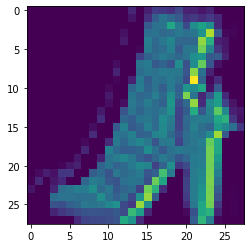

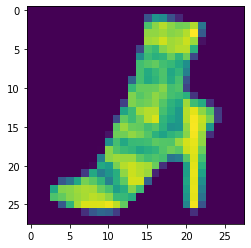

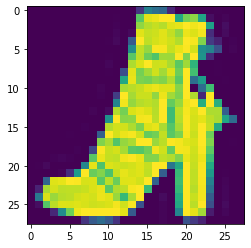

In [ ]:
py.imshow(same[1])
py.show()
py.imshow(same[0])
py.show()
#temp=train_data[sample].transpose((1,2,0))
temp=train_data[sample].reshape(28,28)
py.imshow(temp)

### Model Test

In [ ]:
#full test: 
pred_1,_=dense_jit(params,test_data)
pred_1=np.argmax(pred_1,axis=1)
target_1=np.argmax(test_label,axis=1)
print(len(np.where(pred_1 == target_1)[0])/10000 *100)

90.53999999999999
